## Input

In [110]:
import pandas as pd
## Importing the csv file into a dava frame.
df = pd.read_csv(r'C:\Users\Morga\programsMG\NaturalLanguageProcessing\preprocessed_kindle_review.csv')

 ## Preprocessing

In [111]:
#checking for null values
df.isnull().sum()

Unnamed: 0    0
rating        0
reviewText    0
summary       0
dtype: int64

In [112]:
# Finding the number of examples per label
labelcounts = df['rating'].value_counts()
labelcounts

4    3000
5    3000
1    2000
2    2000
3    2000
Name: rating, dtype: int64

In [113]:
# Finding the baseline and raw agreement
print('baseline and raw agreement:')
print(3000/sum(labelcounts))
print(1/5)

baseline and raw agreement:
0.25
0.2


In [114]:
# Splitting the data into lists
M = df['reviewText'].tolist()
y = df['rating'].tolist()

In [115]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#setting an empty list to save the compound scores into.
vs_list_compound = [] 
#Looping through to get a compound score for each r
#eview saving it into the compund list created.
for review in M:
    vs = analyzer.polarity_scores(review)
    vs_list = vs['compound']
    vs_list_compound.append(vs_list) 

In [116]:
# creating a list to place predictions into
sent1_5 =[]
#selecting specific compund score range
#If the score is found in that range
#adding a numeric representation (1-5)
#into the list of predictions
for item in vs_list_compound:
    if item <=(-.6):
        sent1_5.append(1)
    elif item >-.6 and item <=-.2:
        sent1_5.append(2)
    elif item >-.2 and item <=.2:
        sent1_5.append(3)
    elif item >.2 <=.6 and item:
        sent1_5.append(4)
    elif item >.6 and item:
        sent1_5.append(5)

In [117]:
from sklearn.metrics import accuracy_score
accuracy_score(y,sent1_5)

0.3010833333333333

In [118]:
## Using Regular expressions to remove words containing multiple repeats of characters
import re
X=[]
for item in M:
    X.append(re.sub(r'([a-zA-Z0-9_<>-])\1+', r'\1\1', item))

In [119]:
## comment out to use full data set
#X=X[:1000]
#y= y[:1000]

In [120]:
len(X)

12000

## Vectorization

In [121]:
from nltk.tokenize import word_tokenize 

textdocuments=[]
for item in X:
     textdocuments.append(word_tokenize(item))

In [122]:
def merge(list1, list2):
    merged_list = [(list1 [i], list2 [i]) for i in range (0, len(list1))]
    return merged_list

In [123]:
documents = merge(textdocuments,y) 

In [124]:
print(len(documents[0]))
print(documents[0])

2
(['This', 'book', 'was', 'the', 'very', 'first', 'bookmobile', 'book', 'I', 'bought', 'when', 'I', 'was', 'in', 'the', 'school', 'book', 'club', '.', 'I', 'loved', 'the', 'story', 'then', 'and', 'I', 'bet', 'a', 'dollar', 'to', 'a', 'donut', 'I', 'will', 'love', 'it', 'again', '.', 'If', 'my', 'memory', 'serves', ',', 'I', 'bought', 'this', 'book', 'in', '5th', 'grade', '.', 'That', 'would', 'have', 'been', 'about', '1961', '.', 'I', 'am', 'looking', 'forward', 'to', 'reliving', 'the', 'memories', '.'], 5)


## NLTK approach

## BOW classification (MNB)

In [125]:
import nltk
# get all words from all kindle reviews and put into a frequency distribution
#   note lowercase, but no stemming or stopwords
all_words_list = [word for (sent,cat) in documents for word in sent]
all_words = nltk.FreqDist(all_words_list)
# get the 2000 most frequently appearing keywords in the corpus
word_items = all_words.most_common(2000)
word_features = [word for (word,count) in word_items]

In [126]:
# define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'contains(keyword)' and is true or false depending
# on whether that keyword is in the document
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

In [127]:
# using the funtion to create a list of dictionaries
featuresets = [document_features(d, word_features) for (d, c) in documents]

In [128]:
# Using the list of dicts to create a data frame
X_fs = pd.DataFrame(featuresets)

In [129]:
pd.set_option('max_columns', None)
X_fs.isnull().any().value_counts()

False    2000
dtype: int64

In [130]:
# import the module
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

In [131]:
# initialize the model
mnb1_fs = MultinomialNB()

In [132]:
# use the training data to train the model
mnb_model_fs = mnb1_fs.fit(X_fs,y)
#cross validation score
mnb_cv_scores_fs = cross_val_score(mnb1_fs, X_fs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_fs = round(np.mean(mnb_cv_scores_fs),4)
print(mnb_cv_score_fs)

0.4939


In [133]:
# print confusion matrix and classification report
mnb_pred_fs = cross_val_predict(mnb1_fs, X_fs, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_pred_fs, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_fs_report= classification_report(y, mnb_pred_fs, target_names=target_names)
print(mnb_fs_report)

[[1300  435  113   66   86]
 [ 689  741  305  150  115]
 [ 285  393  649  438  235]
 [ 155  164  496 1135 1050]
 [ 131   46  128  593 2102]]

              precision    recall  f1-score   support

           1       0.51      0.65      0.57      2000
           2       0.42      0.37      0.39      2000
           3       0.38      0.32      0.35      2000
           4       0.48      0.38      0.42      3000
           5       0.59      0.70      0.64      3000

    accuracy                           0.49     12000
   macro avg       0.47      0.48      0.47     12000
weighted avg       0.48      0.49      0.48     12000



In [134]:
mnb_f1_1_score_fs = float(mnb_fs_report[94:98])
mnb_f1_2_score_fs = float(mnb_fs_report[148:152])
mnb_f1_3_score_fs = float(mnb_fs_report[202:206])
mnb_f1_4_score_fs = float(mnb_fs_report[256:260])
mnb_f1_5_score_fs = float(mnb_fs_report[310:314])

##  BOW classification + Bigrams (MNB)

In [135]:
# set up for using bigrams
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [136]:
# create the bigram finder on all the words in sequence
finder = BigramCollocationFinder.from_words(all_words_list)

In [137]:
# define the top 500 bigrams using the chi squared measure
bigram_features = finder.nbest(bigram_measures.chi_sq, 500)

In [138]:
# define features that include words as before 
# add the most frequent significant bigrams
# this function takes the list of words in a document as an argument and returns a feature dictionary
# it depends on the variables word_features and bigram_features
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features

In [139]:
# using the funtion to create a list of dictionaries
bigram_featuresets = [bigram_document_features(d, word_features, bigram_features) for (d, c) in documents]

In [140]:
X_bifs = pd.DataFrame(bigram_featuresets)

In [141]:
# import the module
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np


In [142]:
# initialize the model
mnb1_bifs = MultinomialNB()
# use the training data to train the model
mnb_model_bifs = mnb1_bifs.fit(X_bifs,y)
#cross validation score
mnb_cv_scores_bifs = cross_val_score(mnb1_bifs, X_bifs, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_bifs = round(np.mean(mnb_cv_scores_bifs),4)
print(mnb_cv_score_bifs)

0.4946


In [143]:
# print confusion matrix and classification report
mnb_pred_bifs = cross_val_predict(mnb1_bifs, X_bifs, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_pred_bifs, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_bifs_report= classification_report(y, mnb_pred_bifs, target_names=target_names)
print(mnb_bifs_report)

[[1284  447  111   71   87]
 [ 680  743  304  155  118]
 [ 279  394  642  451  234]
 [ 147  163  484 1168 1038]
 [ 125   46  126  605 2098]]

              precision    recall  f1-score   support

           1       0.51      0.64      0.57      2000
           2       0.41      0.37      0.39      2000
           3       0.39      0.32      0.35      2000
           4       0.48      0.39      0.43      3000
           5       0.59      0.70      0.64      3000

    accuracy                           0.49     12000
   macro avg       0.47      0.48      0.48     12000
weighted avg       0.48      0.49      0.49     12000



In [144]:
mnb_f1_1_score_bifs = float(mnb_bifs_report[94:98])
mnb_f1_2_score_bifs = float(mnb_bifs_report[148:152])
mnb_f1_3_score_bifs = float(mnb_bifs_report[202:206])
mnb_f1_4_score_bifs = float(mnb_bifs_report[256:260])
mnb_f1_5_score_bifs = float(mnb_bifs_report[310:314])

## Sklearn approach 

## MNB Unigram

In [145]:
# import the  module
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np

In [146]:
from sklearn.feature_extraction.text import CountVectorizer
bool_vectorizer = CountVectorizer(encoding='latin-1'
                                                 , binary=True
                                                 , min_df=5 
                                                 , max_features=2450)

In [147]:
# fitting and transforming the training data using the count vectorizer
X_train_bool_mnb = bool_vectorizer.fit_transform(X)

In [148]:
# initialize the  model
mnb1 = MultinomialNB()
# use the training data to train the model
#mnb_model = mnb1.fit(X_train_mnb,y)
#cross validation score
mnb_cv_scores = cross_val_score(mnb1, X_train_bool_mnb, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score = round(np.mean(mnb_cv_scores),4)
print(mnb_cv_score)

0.5032


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
unigram_tfidf_vectorizer_mnb = TfidfVectorizer(encoding='latin-1'
                                                 , use_idf=True
                                                 , min_df=5 
                                                 , max_features=2450
                                                )

In [150]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb = unigram_tfidf_vectorizer_mnb.fit_transform(X)

In [151]:
# initialize the  model
mnb1 = MultinomialNB()
# use the training data to train the model
#mnb_model = mnb1.fit(X_train_mnb,y)
#cross validation score
mnb_cv_scores = cross_val_score(mnb1, X_train_mnb, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score = round(np.mean(mnb_cv_scores),4)
print(mnb_cv_score)

0.503


In [152]:
from sklearn.model_selection import cross_val_predict
# print confusion matrix and classification report
mnb_pred = cross_val_predict(mnb1, X_train_mnb, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_pred, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_report= classification_report(y, mnb_pred, target_names=target_names)
print(mnb_report)

[[1144  435   47  253  121]
 [ 502  738  158  468  134]
 [ 147  324  323 1013  193]
 [  57   93  134 1791  925]
 [  53   22   15  870 2040]]

              precision    recall  f1-score   support

           1       0.60      0.57      0.59      2000
           2       0.46      0.37      0.41      2000
           3       0.48      0.16      0.24      2000
           4       0.41      0.60      0.48      3000
           5       0.60      0.68      0.64      3000

    accuracy                           0.50     12000
   macro avg       0.51      0.48      0.47     12000
weighted avg       0.51      0.50      0.49     12000



In [153]:
mnb_f1_1_score = float(mnb_report[94:98])
mnb_f1_2_score = float(mnb_report[148:152])
mnb_f1_3_score = float(mnb_report[202:206])
mnb_f1_4_score = float(mnb_report[256:260])
mnb_f1_5_score = float(mnb_report[310:314])

## Stemming

In [154]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [155]:
# import the  module
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
unigram_tfidf_vectorizer_mnb_stem = TfidfVectorizer(encoding='latin-1'
                                                 , use_idf=True
                                                 , min_df=5 
                                                 , max_features=2450
                                                 ,analyzer=stemmed_words
                                                )

In [157]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb_stem = unigram_tfidf_vectorizer_mnb_stem.fit_transform(X)

In [158]:
# initialize the  model
mnb_stem = MultinomialNB()
# use the training data to train the model
#mnb_model = mnb1.fit(X_train_mnb,y)
#cross validation score
mnb_cv_scores_stem = cross_val_score(mnb_stem, X_train_mnb_stem, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_stem = round(np.mean(mnb_cv_scores_stem),4)
print(mnb_cv_score_stem)

0.4969


In [159]:
from sklearn.model_selection import cross_val_predict
# print confusion matrix and classification report
mnb_stem_pred = cross_val_predict(mnb1, X_train_mnb, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_stem_pred, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_stem_report= classification_report(y, mnb_stem_pred, target_names=target_names)
print(mnb_stem_report)

[[1144  435   47  253  121]
 [ 502  738  158  468  134]
 [ 147  324  323 1013  193]
 [  57   93  134 1791  925]
 [  53   22   15  870 2040]]

              precision    recall  f1-score   support

           1       0.60      0.57      0.59      2000
           2       0.46      0.37      0.41      2000
           3       0.48      0.16      0.24      2000
           4       0.41      0.60      0.48      3000
           5       0.60      0.68      0.64      3000

    accuracy                           0.50     12000
   macro avg       0.51      0.48      0.47     12000
weighted avg       0.51      0.50      0.49     12000



In [160]:
mnb_stem_f1_1_score = float(mnb_stem_report[94:98])
mnb_stem_f1_2_score = float(mnb_stem_report[148:152])
mnb_stem_f1_3_score = float(mnb_stem_report[202:206])
mnb_stem_f1_4_score = float(mnb_stem_report[256:260])
mnb_stem_f1_5_score = float(mnb_stem_report[310:314])

## MNB Ngram (adding bigrams)

In [161]:
from sklearn.feature_extraction.text import CountVectorizer
bool_vectorizer = CountVectorizer(encoding='latin-1'
                                                 , ngram_range=(1,2)
                                                 , binary=True
                                                 , min_df=5 
                                                 , max_features=3000)

In [162]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb_bool_2 = bool_vectorizer.fit_transform(X)

In [166]:
# initialize the  model
mnb2 = MultinomialNB()
# use the training data to train the model
#mnb_model_2 = mnb2.fit(X_train_mnb_2,y)
#cross validation score
mnb_cv_scores_2 = cross_val_score(mnb2, X_train_mnb_bool_2, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_2 = round(np.mean(mnb_cv_scores_2),4)
print(mnb_cv_score_2)

0.5118


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_tfidf_vectorizer_mnb = TfidfVectorizer(encoding='latin-1'
                                                 ,ngram_range=(1,2)
                                                , use_idf=True
                                                 , min_df=5
                                                 , max_features=3000
                                                                  )

In [168]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb_2 = ngram_tfidf_vectorizer_mnb.fit_transform(X)

In [169]:
# initialize the  model
mnb2 = MultinomialNB()
# use the training data to train the model
#mnb_model_2 = mnb2.fit(X_train_mnb_2,y)
#cross validation score
mnb_cv_scores_2 = cross_val_score(mnb2, X_train_mnb_2, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_2 = round(np.mean(mnb_cv_scores_2),4)
print(mnb_cv_score_2)

0.5136


In [170]:
# print confusion matrix and classification report
mnb_pred_2 = cross_val_predict(mnb2, X_train_mnb_2, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_pred_2, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_2_report= classification_report(y, mnb_pred_2, target_names=target_names)
print(mnb_2_report)

[[1142  447   66  227  118]
 [ 498  807  194  365  136]
 [ 152  371  418  869  190]
 [  47   92  213 1699  949]
 [  47   23   18  815 2097]]

              precision    recall  f1-score   support

           1       0.61      0.57      0.59      2000
           2       0.46      0.40      0.43      2000
           3       0.46      0.21      0.29      2000
           4       0.43      0.57      0.49      3000
           5       0.60      0.70      0.65      3000

    accuracy                           0.51     12000
   macro avg       0.51      0.49      0.49     12000
weighted avg       0.51      0.51      0.50     12000



In [171]:
mnb_f1_1_score_2 = float(mnb_2_report[94:98])
mnb_f1_2_score_2 = float(mnb_2_report[148:152])
mnb_f1_3_score_2 = float(mnb_2_report[202:206])
mnb_f1_4_score_2 = float(mnb_2_report[256:260])
mnb_f1_5_score_2 = float(mnb_2_report[310:314])

## mnb Trigrams

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_tfidf_vectorizer_mnb_tri = TfidfVectorizer(encoding='latin-1'
                                                 ,ngram_range=(1,3)
                                                 , use_idf=True
                                                 , min_df=5
                                                 , max_features=2450
                                                )

In [173]:
# fitting and transforming the training data using the count vectorizer
X_train_mnb_tri = ngram_tfidf_vectorizer_mnb_tri.fit_transform(X)

In [174]:
# initialize the  model
mnb_tri = MultinomialNB()
# use the training data to train the model
#mnb_model_2 = mnb2.fit(X_train_mnb_2,y)
#cross validation score
mnb_cv_scores_tri = cross_val_score(mnb_tri, X_train_mnb_tri, y, cv=10)
#finding the overall average accuracy.
mnb_cv_score_tri = round(np.mean(mnb_cv_scores_tri),4)
print(mnb_cv_score_tri)

0.51


In [175]:
# print confusion matrix and classification report
mnb_pred_3 = cross_val_predict(mnb_tri, X_train_mnb_tri, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, mnb_pred_3, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
mnb_3_report= classification_report(y, mnb_pred_3, target_names=target_names)
print(mnb_3_report)

[[1132  450   66  229  123]
 [ 500  769  223  380  128]
 [ 166  347  452  844  191]
 [  55   95  217 1708  925]
 [  63   29   29  820 2059]]

              precision    recall  f1-score   support

           1       0.59      0.57      0.58      2000
           2       0.46      0.38      0.42      2000
           3       0.46      0.23      0.30      2000
           4       0.43      0.57      0.49      3000
           5       0.60      0.69      0.64      3000

    accuracy                           0.51     12000
   macro avg       0.51      0.49      0.49     12000
weighted avg       0.51      0.51      0.50     12000



In [176]:
mnb_f1_1_score_3 = float(mnb_3_report[94:98])
mnb_f1_2_score_3 = float(mnb_3_report[148:152])
mnb_f1_3_score_3 = float(mnb_3_report[202:206])
mnb_f1_4_score_3 = float(mnb_3_report[256:260])
mnb_f1_5_score_3 = float(mnb_3_report[310:314])

## SVM Ngram

In [177]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# initialize the  model

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_tfidf_vectorizer_svm = TfidfVectorizer(encoding='latin-1'
                                            , ngram_range=(1,2)
                                            , use_idf=True
                                            , max_df=.5
                                            , max_features=10000
                                            )

In [179]:
# fitting and transforming the training data using the count vectorizer
X_train_svm_2 = ngram_tfidf_vectorizer_svm.fit_transform(X)

In [180]:
#svclin = SVC() 
svclin = LinearSVC(C=1)
# use the training data to train the model
#svm_model_2 = svm2.fit(X_train_svm_2,y)
#cross validation score
svm_cv_scores_2 = cross_val_score(svclin, X_train_svm_2, y, cv=10)
#finding the overall average accuracy.
svm_cv_score_2 = round(np.mean(svm_cv_scores_2),4)
print(svm_cv_score_2)

0.5012


In [181]:
# print confusion matrix and classification report
svm_pred_2 = cross_val_predict(svclin, X_train_svm_2, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, svm_pred_2, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
svm_2_report= classification_report(y, svm_pred_2, target_names=target_names)
print(svm_2_report)

[[1176  503  128   99   94]
 [ 598  741  348  207  106]
 [ 165  379  691  584  181]
 [  90  157  380 1431  942]
 [  69   46  119  791 1975]]

              precision    recall  f1-score   support

           1       0.56      0.59      0.57      2000
           2       0.41      0.37      0.39      2000
           3       0.41      0.35      0.38      2000
           4       0.46      0.48      0.47      3000
           5       0.60      0.66      0.63      3000

    accuracy                           0.50     12000
   macro avg       0.49      0.49      0.49     12000
weighted avg       0.49      0.50      0.50     12000



In [182]:
svm_f1_1_score_2 = float(mnb_2_report[94:98])
svm_f1_2_score_2 = float(mnb_2_report[148:152])
svm_f1_3_score_2 = float(mnb_2_report[202:206])
svm_f1_4_score_2 = float(mnb_2_report[256:260])
svm_f1_5_score_2 = float(mnb_2_report[310:314])

## SVC Ngram

In [183]:
from sklearn.svm import SVC
# initialize the  model
svc = SVC(C=1)
svc_poly = SVC(C=10,kernel='poly')
svc_sigmoid = SVC(C=1,kernel='sigmoid')

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_tfidf_vectorizer_svc = TfidfVectorizer(encoding='latin-1'
                                                 , ngram_range=(1,2)
                                                 , use_idf=True
                                                 , min_df=5
                                                 , max_features=3000
                                            )

In [185]:
# fitting and transforming the training data using the count vectorizer
X_train_svc = ngram_tfidf_vectorizer_svc.fit_transform(X)

In [186]:
# use the training data to train the model
#svc_model_ = svc.fit(X_train_svc,y)
#cross validation score
svc_cv_scores = cross_val_score(svc, X_train_svc, y, cv=10)
#finding the overall average accuracy.
svc_cv_score = round(np.mean(svc_cv_scores),4)
print(svc_cv_score)

0.5198


In [187]:
# print confusion matrix and classification report
svc_pred = cross_val_predict(svc, X_train_svc, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, svc_pred, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
svc_report= classification_report(y, svc_pred, target_names=target_names)
print(svc_report)

[[1157  532  105  102  104]
 [ 524  865  285  230   96]
 [ 128  422  559  711  180]
 [  64  131  296 1613  896]
 [  58   39   57  802 2044]]

              precision    recall  f1-score   support

           1       0.60      0.58      0.59      2000
           2       0.43      0.43      0.43      2000
           3       0.43      0.28      0.34      2000
           4       0.47      0.54      0.50      3000
           5       0.62      0.68      0.65      3000

    accuracy                           0.52     12000
   macro avg       0.51      0.50      0.50     12000
weighted avg       0.51      0.52      0.51     12000



In [188]:
svc_f1_1_score_2 = float(svc_report[94:98])
svc_f1_2_score_2 = float(svc_report[148:152])
svc_f1_3_score_2 = float(svc_report[202:206])
svc_f1_4_score_2 = float(svc_report[256:260])
svc_f1_5_score_2 = float(svc_report[310:314])

In [189]:
# use the training data to train the model
#svc_model_poly = svc_poly.fit(X_train_svc,y)
#cross validation score
svc_cv_scores_poly = cross_val_score(svc_poly, X_train_svc, y, cv=10)
#finding the overall average accuracy.
svc_cv_score_poly = round(np.mean(svc_cv_scores_poly),4)
print(svc_cv_score_poly)

0.4867


In [190]:
# print confusion matrix and classification report
svc_poly_pred = cross_val_predict(svc_poly, X_train_svc, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, svc_poly_pred, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
svc_poly_report= classification_report(y, svc_poly_pred, target_names=target_names)
print(svc_poly_report)

[[ 988  368   47  300  297]
 [ 418  626  168  517  271]
 [ 101  282  334  979  304]
 [  31   60  152 1726 1031]
 [  25   19   24  766 2166]]

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      2000
           2       0.46      0.31      0.37      2000
           3       0.46      0.17      0.25      2000
           4       0.40      0.58      0.47      3000
           5       0.53      0.72      0.61      3000

    accuracy                           0.49     12000
   macro avg       0.50      0.45      0.45     12000
weighted avg       0.49      0.49      0.47     12000



In [191]:
svc_poly_f1_1_score_2 = float(svc_poly_report[94:98])
svc_poly_f1_2_score_2 = float(svc_poly_report[148:152])
svc_poly_f1_3_score_2 = float(svc_poly_report[202:206])
svc_poly_f1_4_score_2 = float(svc_poly_report[256:260])
svc_poly_f1_5_score_2 = float(svc_poly_report[310:314])

In [192]:
# use the training data to train the model
#svc_model_sigmoid = svc_sigmoid.fit(X_train_svc,y)
#cross validation score
svc_cv_scores_sigmoid = cross_val_score(svc_sigmoid, X_train_svc, y, cv=10)
#finding the overall average accuracy.
svc_cv_score_sigmoid = round(np.mean(svc_cv_scores_sigmoid),4)
print(svc_cv_score_sigmoid)

0.5094


In [193]:
# print confusion matrix and classification report
svc_sigmoid_pred = cross_val_predict(svc_sigmoid, X_train_svc, y, cv=10)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, svc_sigmoid_pred, labels=[1,2,3,4,5])
print(cm)
print()

from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
svc_sigmoid_report= classification_report(y, svc_sigmoid_pred, target_names=target_names)
print(svc_sigmoid_report)

[[1151  553  122   92   82]
 [ 573  846  317  185   79]
 [ 156  421  639  627  157]
 [  73  163  370 1500  894]
 [  75   50  112  786 1977]]

              precision    recall  f1-score   support

           1       0.57      0.58      0.57      2000
           2       0.42      0.42      0.42      2000
           3       0.41      0.32      0.36      2000
           4       0.47      0.50      0.48      3000
           5       0.62      0.66      0.64      3000

    accuracy                           0.51     12000
   macro avg       0.50      0.50      0.49     12000
weighted avg       0.50      0.51      0.51     12000



In [194]:
svc_sigmoid_f1_1_score_2 = float(svc_sigmoid_report[94:98])
svc_sigmoid_f1_2_score_2 = float(svc_sigmoid_report[148:152])
svc_sigmoid_f1_3_score_2 = float(svc_sigmoid_report[202:206])
svc_sigmoid_f1_4_score_2 = float(svc_sigmoid_report[256:260])
svc_sigmoid_f1_5_score_2 = float(svc_sigmoid_report[310:314])

## Accuracy Compare

In [1]:
acclist={'NLTK MNB':0.494
         ,'Sklearn MNB':0.503
         ,'NLTK Bigrams':0.4946
         ,'Sklearn unigrams + bigrams':0.5136
         ,'Sklearn Unigram + Stemming':0.4969
         ,'Sklearn Unigram, Bigrams, and Trigrams':0.51
         ,'Linear SVM':0.501
         ,'SVC RBF':0.5014
         ,'SVC Poly':0.4143
         ,'SVC Sigmoid':0.491
         }

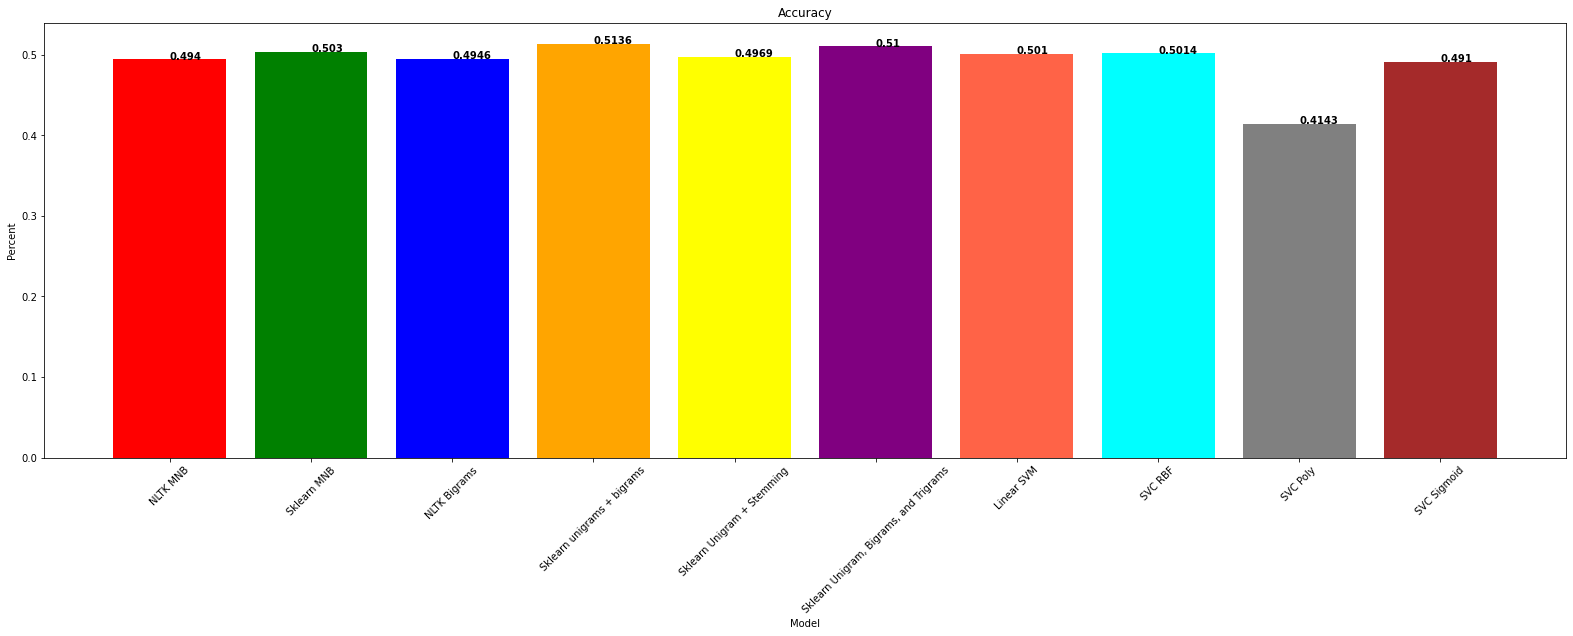

In [2]:
import matplotlib.pyplot as plt

# function to add value labels
def addlabels(y):
    for i in range(len(y)):
        plt.text(i,y[i],y[i],fontweight = 'bold')


values = list(acclist.values())
names = list(acclist.keys())
colors = ['red','green','blue','orange','yellow','purple','tomato','cyan','gray','brown'
]
plt.figure(figsize=(60, 8))

plt.subplot(121)
plt.bar(names
        ,values
        ,color= colors
       )

plt.xticks(rotation= 45)
plt.ylabel('Percent')
plt.xlabel('Model')
plt.title('Accuracy')

addlabels(values)
plt.show()

## F1_score Compare

In [197]:

f1list={'mnb_f1_1_score_fs':mnb_f1_1_score_fs 
         ,'mnb_f1_2_score_fs':mnb_f1_2_score_fs 
         ,'mnb_f1_3_score_fs':mnb_f1_3_score_fs 
         ,'mnb_f1_4_score_fs':mnb_f1_4_score_fs 
         ,'mnb_f1_5_score_fs':mnb_f1_5_score_fs
        
         ,'mnb_f1_1_score':mnb_f1_1_score
         ,'mnb_f1_2_score':mnb_f1_2_score
         ,'mnb_f1_3_score':mnb_f1_3_score
         ,'mnb_f1_4_score':mnb_f1_4_score
         ,'mnb_f1_5_score':mnb_f1_5_score
        
         ,'mnb_f1_1_score_bifs':mnb_f1_1_score_bifs
         ,'mnb_f1_2_score_bifs':mnb_f1_2_score_bifs
         ,'mnb_f1_3_score_bifs':mnb_f1_3_score_bifs
         ,'mnb_f1_4_score_bifs':mnb_f1_4_score_bifs
         ,'mnb_f1_5_score_bifs':mnb_f1_5_score_bifs
        
         ,'mnb_f1_1_score_2':mnb_f1_1_score_2
         ,'mnb_f1_2_score_2':mnb_f1_2_score_2
         ,'mnb_f1_3_score_2':mnb_f1_3_score_2
         ,'mnb_f1_4_score_2':mnb_f1_4_score_2
         ,'mnb_f1_5_score_2':mnb_f1_5_score_2
        
         ,'mnb_stem_f1_1_score':mnb_stem_f1_1_score
         ,'mnb_stem_f1_2_score':mnb_stem_f1_2_score
         ,'mnb_stem_f1_3_score':mnb_stem_f1_3_score
         ,'mnb_stem_f1_4_score':mnb_stem_f1_4_score
         ,'mnb_stem_f1_5_score':mnb_stem_f1_5_score
        
         ,'mnb_f1_1_score_3':mnb_f1_1_score_3 
         ,'mnb_f1_2_score_3':mnb_f1_2_score_3
         ,'mnb_f1_3_score_3':mnb_f1_3_score_3 
         ,'mnb_f1_4_score_3':mnb_f1_4_score_3
         ,'mnb_f1_5_score_3':mnb_f1_5_score_3
         
         ,'svm_f1_1_score_2':svm_f1_1_score_2
         ,'svm_f1_2_score_2':svm_f1_2_score_2
         ,'svm_f1_3_score_2':svm_f1_3_score_2
         ,'svm_f1_4_score_2':svm_f1_4_score_2
         ,'svm_f1_5_score_2':svm_f1_5_score_2
        
         ,'svc_f1_1_score_2':svc_f1_1_score_2
         ,'svc_f1_2_score_2':svc_f1_2_score_2
         ,'svc_f1_3_score_2':svc_f1_3_score_2
         ,'svc_f1_4_score_2':svc_f1_4_score_2
         ,'svc_f1_5_score_2':svc_f1_5_score_2
        
         ,'svc_poly_f1_1_score_2':svc_poly_f1_1_score_2
         ,'svc_poly_f1_2_score_2':svc_poly_f1_2_score_2
         ,'svc_poly_f1_3_score_2':svc_poly_f1_3_score_2
         ,'svc_poly_f1_4_score_2':svc_poly_f1_4_score_2
         ,'svc_poly_f1_5_score_2':svc_poly_f1_5_score_2
        
         ,'svc_sigmoid_f1_1_score_2':svc_sigmoid_f1_1_score_2
         ,'svc_sigmoid_f1_2_score_2':svc_sigmoid_f1_2_score_2
         ,'svc_sigmoid_f1_3_score_2':svc_sigmoid_f1_3_score_2
         ,'svc_sigmoid_f1_4_score_2':svc_sigmoid_f1_4_score_2
         ,'svc_sigmoid_f1_5_score_2':svc_sigmoid_f1_5_score_2
    }

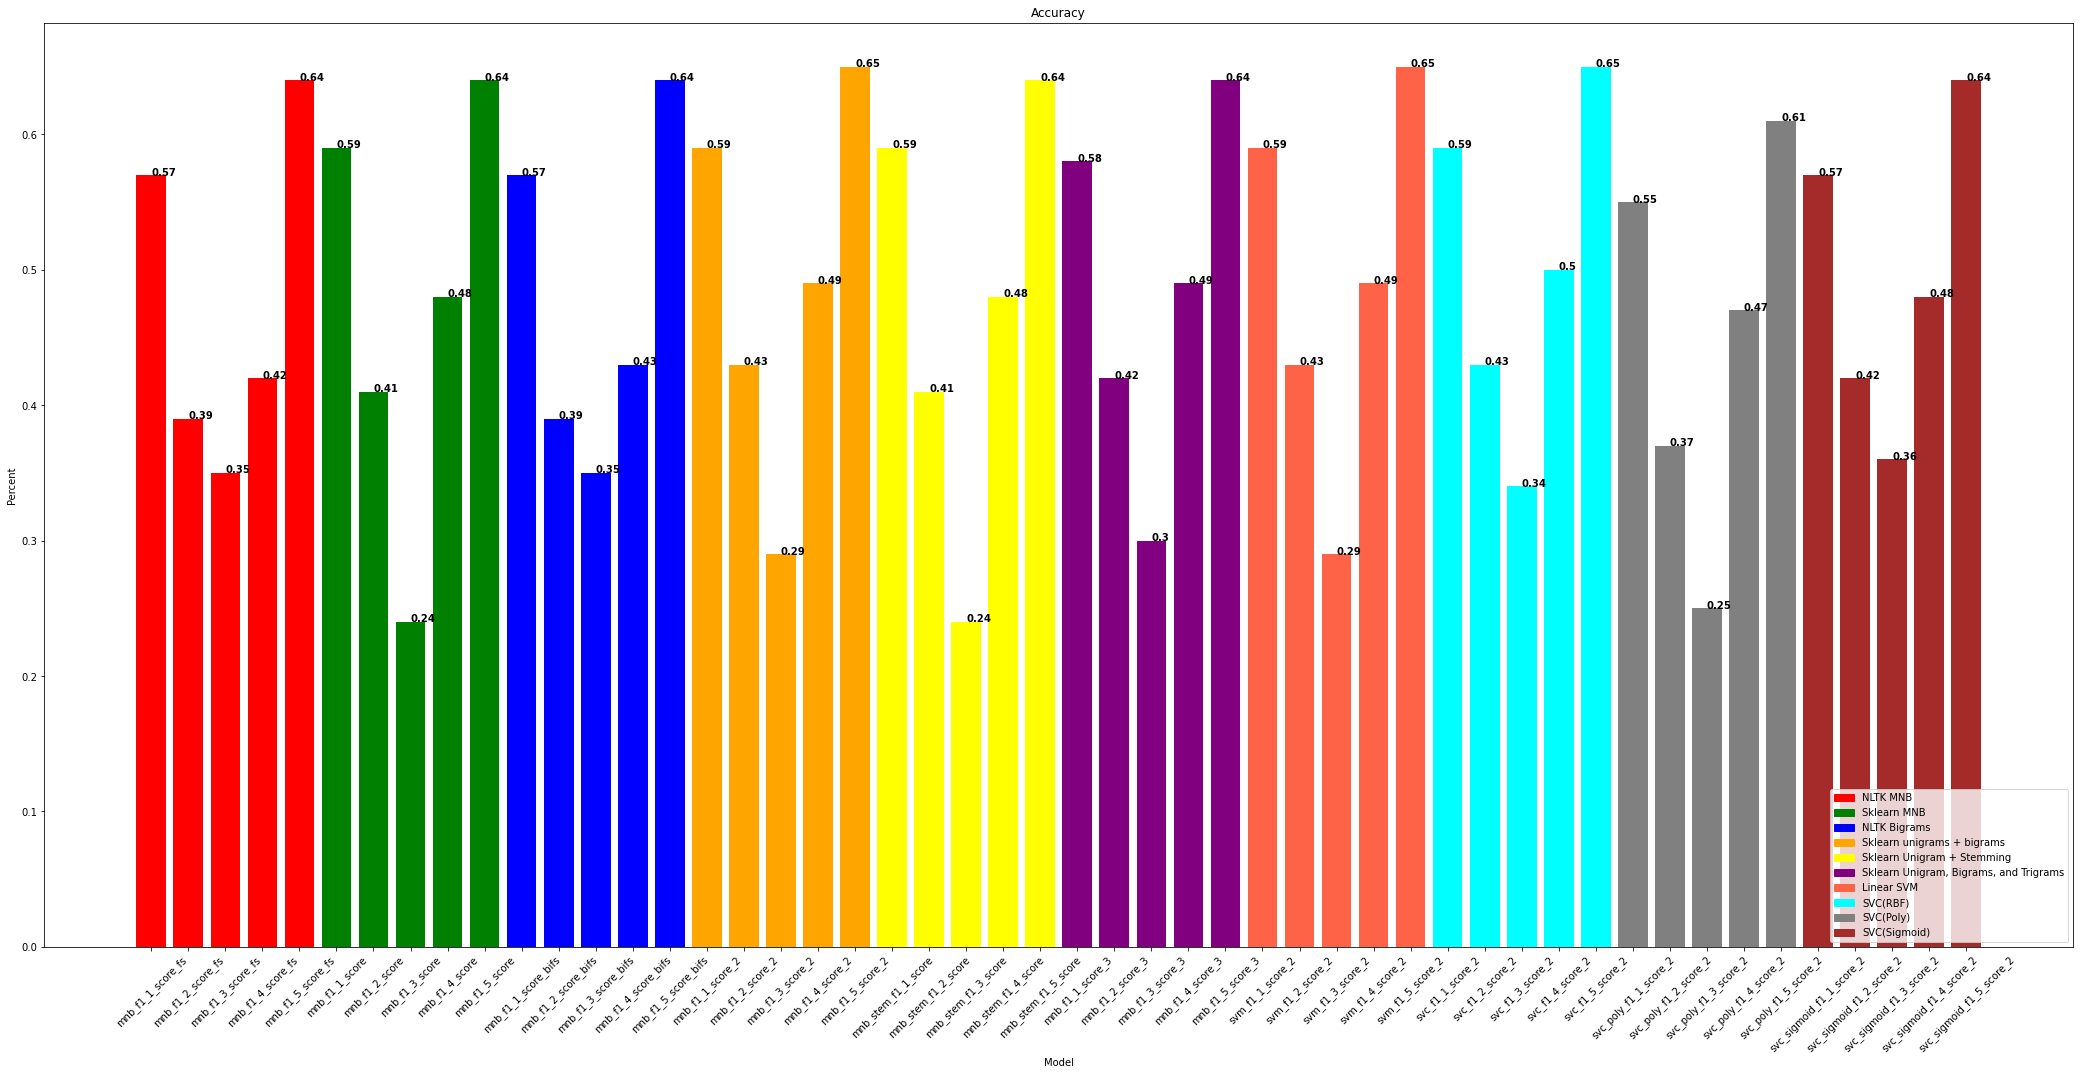

In [198]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# function to add value labels
def addlabels(y):
    for i in range(len(y)):
        plt.text(i,y[i],y[i],fontweight = 'bold')


values = list(f1list.values())
names = list(f1list.keys())
colors = ['red','red','red','red','red'
          ,'green','green','green','green','green'
          ,'blue','blue','blue','blue','blue'
          ,'orange','orange','orange','orange','orange'
          ,'yellow','yellow','yellow','yellow','yellow'
          ,'purple','purple','purple','purple','purple'
          ,'tomato','tomato','tomato','tomato','tomato'
          ,'cyan','cyan','cyan','cyan','cyan'
          ,'gray','gray','gray','gray','gray'
          ,'brown','brown','brown','brown','brown'
]
plt.figure(figsize=(80, 17))

plt.subplot(121)
plt.bar(names
        ,values
        ,color= colors
       )
plt.xticks(rotation= 45)
#plt.show()
# legend manually added
l1 = mpatches.Patch(color='red', label='NLTK MNB')
l2 = mpatches.Patch(color='green', label='Sklearn MNB')
l3 = mpatches.Patch(color='blue', label='NLTK Bigrams')
l4 = mpatches.Patch(color='orange', label='Sklearn unigrams + bigrams')
l5 = mpatches.Patch(color='yellow', label='Sklearn Unigram + Stemming')
l6 = mpatches.Patch(color='purple', label='Sklearn Unigram, Bigrams, and Trigrams')
l7 = mpatches.Patch(color='tomato', label='Linear SVM')
l8 = mpatches.Patch(color='cyan', label='SVC(RBF)')
l9 = mpatches.Patch(color='gray', label='SVC(Poly)')
l10 = mpatches.Patch(color='brown', label='SVC(Sigmoid)')




plt.ylabel('Percent')
plt.xlabel('Model')
plt.title('Accuracy')

addlabels(values)
plt.legend(handles=[l1, l2, l3,l4,l5,l6,l7,l8,l9,l10], loc=4)
plt.show()